## Step 1: Import libraries

In [24]:
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf

from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dense, GlobalAveragePooling3D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam



%matplotlib inline

## Step 2: Set Constants

In [8]:
SEED = 137
# using the range from segmentation
# [40:195,35:225,26:137]
# constants to crop images

MIN_WIDTH = 29 # 40
MAX_WIDTH = 215 # 195

MIN_HEIGHT = 45 # 35
MAX_HEIGHT = 239 # 225

MIN_DEPTH = 15 # 26
MAX_DEPTH = 143 # 137

In [9]:
#channel 
channel = 't2'

## Step 3: Load Data

In [10]:
# load data
df = pd.read_pickle(f"../../raw_data/Grade_ID_{channel}_nii.pkl")

# the target columns have to be updated, it's only the fremework
df['Grade'] = df['Grade'].apply(lambda x: 0 if x == 'HGG' else 1)

## Step 4: EDA

In [11]:
print(f"Number of samples: {df[f'{channel}_nii'].shape[0]}")
print(f"Negative examples: {df[df['Grade'] == 0].shape}")
print(f"Positive examples: {df[df['Grade'] == 1].shape}")

print("")
print("Single example Shape:")
print(f"Height: {df[f'{channel}_nii'][0].shape[0]}")
print(f"Width: {df[f'{channel}_nii'][0].shape[1]}")
print(f"Depth: {df[f'{channel}_nii'][0].shape[2]}")

Number of samples: 369
Negative examples: (293, 3)
Positive examples: (76, 3)

Single example Shape:
Height: 240
Width: 240
Depth: 155


## Step 5: Crop Images and run Augmentation

In [15]:
# crop images
df[f'{channel}_nii'] = df[f'{channel}_nii'].apply(lambda x: np.array(x[MIN_HEIGHT:MAX_HEIGHT,MIN_WIDTH:MAX_WIDTH,MIN_DEPTH:MAX_DEPTH]))
X = df[f'{channel}_nii']
y = df['Grade']

In [16]:
# reshape input data
X = np.array([np.array(val) for val in X])


In [17]:
X[X>840]=840 # set the max value to 840

In [18]:
X = (X - 0)/840 # Min-Max Scaler

In [19]:
X = X.reshape(len(X), X[0].shape[0], X[0].shape[1], X[0].shape[2], 1)

In [20]:
def rotate_image(X, y, i):
    angles = [-30, -20, -15, -10, -5, 5, 10, 15, 20, 30] # set the list of angles to rotate image
    angle = random.choice(angles) # take the random angle from the list
    rotated_example = ndimage.rotate(X[i], angle, reshape=False) # run image rotation
    X = np.append(X, np.expand_dims(rotated_example, axis=0), axis=0) # append rotated image
    y = y.append(pd.Series([y[i]]), ignore_index=True) # append label
    
    return X, y

In [35]:
# create train test split
# create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)
# reset the index of y, so that the indexes of X and y match
y_train = y_train.reset_index(drop=True)

y_test = y_test.reset_index(drop=True)

In [22]:
# conduct augmentation on X_train
if not os.path.isfile(f"{channel}-X_train.npy"):
    
    for i in range(len(X_train)):
        # we run augmentation only for positive examples, i.e. y[i] != 0
        if y_train[i] == 0:
            pass
        else:
            X_train,y_train = rotate_image(X_train, y_train, i)
            X_train,y_train = rotate_image(X_train, y_train, i)
    np.save(f"{channel}-X_train.npy", X_train) #save the channel-X so we don't need always augument the X
    np.save(f"{channel}-y_train.npy", y_train)
else:   #load the X direkly from npy file
    X_train = np.load(f"{channel}-X_train.npy",
                    mmap_mode='r')
    y_train = np.load(f"{channel}-y_train.npy",
                    mmap_mode='r')    

/tmp/ipykernel_13169/1348074226.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y.append(pd.Series([y[i]]), ignore_index=True) # append label


In [36]:
y_train.value_counts()

0    234
1    190
dtype: int64

## Step 6: Define Model

In [37]:
#initialize model
def initialize_model(input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)):
    model = Sequential()
    
    #Add convo layers to the model
    model.add(Conv3D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=2))
    model.add(BatchNormalization())
    
    model.add(Conv3D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv3D(128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=2))
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling3D())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.3))
    
    #Add layer with activation

    model.add(Dense(1, activation='sigmoid'))

    #Model compilation
    # initial_learning_rate = 0.0001
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
    # )
    optim=Adam(learning_rate= 0.01)
    model.compile(loss = 'binary_crossentropy',
                  optimizer = optim,
                  metrics = ['accuracy'])
    return model

In [38]:
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 192, 184, 126, 64  1792      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 96, 92, 63, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 96, 92, 63, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 94, 90, 61, 64)    110656    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 47, 45, 30, 64)   0         
 3D)                                                    

2023-03-13 15:21:24.087538: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-13 15:21:24.088570: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-13 15:21:24.088610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (brain-project-cpu): /proc/driver/nvidia/version does not exist
2023-03-13 15:21:24.091229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
print(f" Size of X_train: {(X_train.size * X_train.itemsize) / 1e9} Gb")

 Size of X_train: 7.833403392 Gb


## Step 7: Train Model

In [40]:
es = EarlyStopping(patience=5, restore_best_weights = True)
history = model.fit(X_train, y_train,
                        epochs = 30,
                        batch_size = 4,
                        callbacks = [es],
                        validation_data=(X_test, y_test),
                        shuffle =True,
                        verbose = 1)
model.save(f'model_glioma_{channel}_nii_baseline')

Epoch 1/30
106/106 [==============================] - 212s 2s/step - loss: 0.6471 - accuracy: 0.6840 - val_loss: 2.1435 - val_accuracy: 0.5566
Epoch 2/30
106/106 [==============================] - 209s 2s/step - loss: 0.5454 - accuracy: 0.7170 - val_loss: 1.5245 - val_accuracy: 0.5566
Epoch 3/30
106/106 [==============================] - 209s 2s/step - loss: 0.5652 - accuracy: 0.7170 - val_loss: 0.8021 - val_accuracy: 0.5566
Epoch 4/30
106/106 [==============================] - 209s 2s/step - loss: 0.5195 - accuracy: 0.7429 - val_loss: 70.5041 - val_accuracy: 0.4434
Epoch 5/30
106/106 [==============================] - 209s 2s/step - loss: 0.4966 - accuracy: 0.7665 - val_loss: 0.6083 - val_accuracy: 0.6981
Epoch 6/30
106/106 [==============================] - 209s 2s/step - loss: 0.4579 - accuracy: 0.7901 - val_loss: 7.0689 - val_accuracy: 0.5566
Epoch 7/30
106/106 [==============================] - 209s 2s/step - loss: 0.5068 - accuracy: 0.7476 - val_loss: 3.3524 - val_accuracy: 0.556

INFO:tensorflow:Assets written to: model_glioma_t2_nii_baseline/assets


INFO:tensorflow:Assets written to: model_glioma_t2_nii_baseline/assets


In [41]:
#plot the learning curve
def plot_loss(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.2)
    ax1.grid(axis="y",linewidth=0.2)    
    
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.2)
    ax2.grid(axis="y",linewidth=0.2)    

    plt.show()    

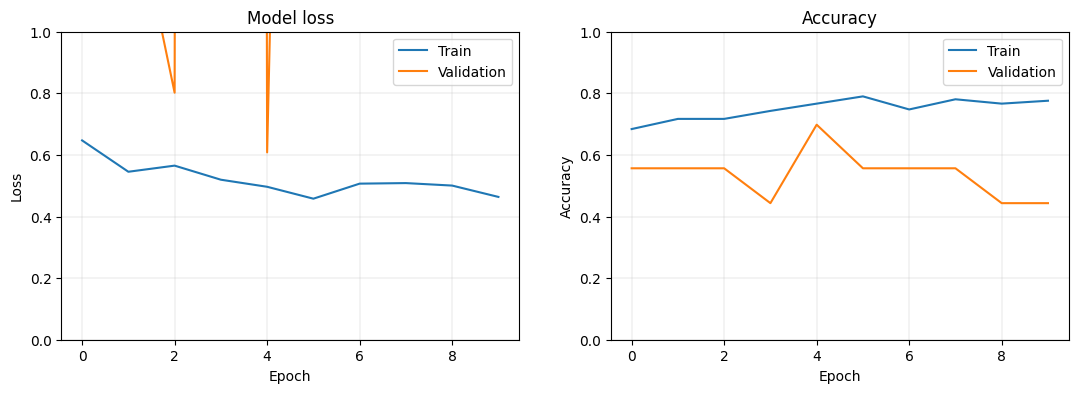

In [42]:
plot_loss(history)

In [46]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
predictions = pd.DataFrame(predictions)



target_names = ['class 0', 'class 1']
print(classification_report(y_test, predictions, target_names=target_names))

4/4 [==============================] - 15s 3s/step
              precision    recall  f1-score   support

     class 0       0.65      1.00      0.79        59
     class 1       1.00      0.32      0.48        47

    accuracy                           0.70       106
   macro avg       0.82      0.66      0.64       106
weighted avg       0.80      0.70      0.65       106

